Mercari Data Exploration

Mercari is an online shopping website where sellers are able to freely set their own prices on products. Unlike for example Amazon, sellers on Mercari are all individuals rather than companies, who already know what prices to place on their products. Therefore, determining prices is more tricky for these individual sellers on Mercari. Not only do they need to take into account the branding and the quality of their item, but also its current condition. Our goal is to provide Mercari with more insight as to how to automatically suggest appropriate prices to their sellers.

In [8]:
#imports

import statistics
from scipy.stats import
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

ModuleNotFoundError: No module named 'researchpy'

In [2]:
path = "/Users/jasonzhou/Documents/GuidedCapstone2"
os.chdir(path)

mercari_data = pd.read_csv("MercariDataCleaned.csv")
mercari_data = mercari_data.drop(columns=['Unnamed: 0'])

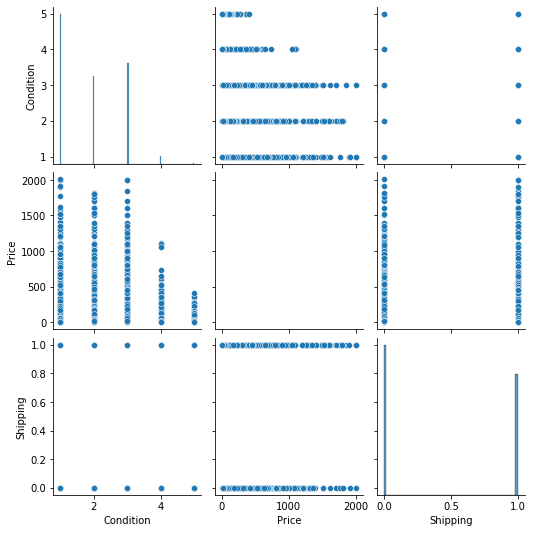

In [22]:
# Lets try to investigate and look for any correlations

sns.pairplot(mercari_data)

We can see that price and condition are somewhat inversely correlated. Keeping in mind that condition
goes from 1 to 5, with 1 being best condition and 5 being worst condition, this matches our intuition. It makes sense
that people aren't able to charge higher prices if their item is not in better condition. Shipping may also slightly affect the price too, as sellers may charge higher prices for their listing if they are the ones paying for shipping. 

<AxesSubplot:>

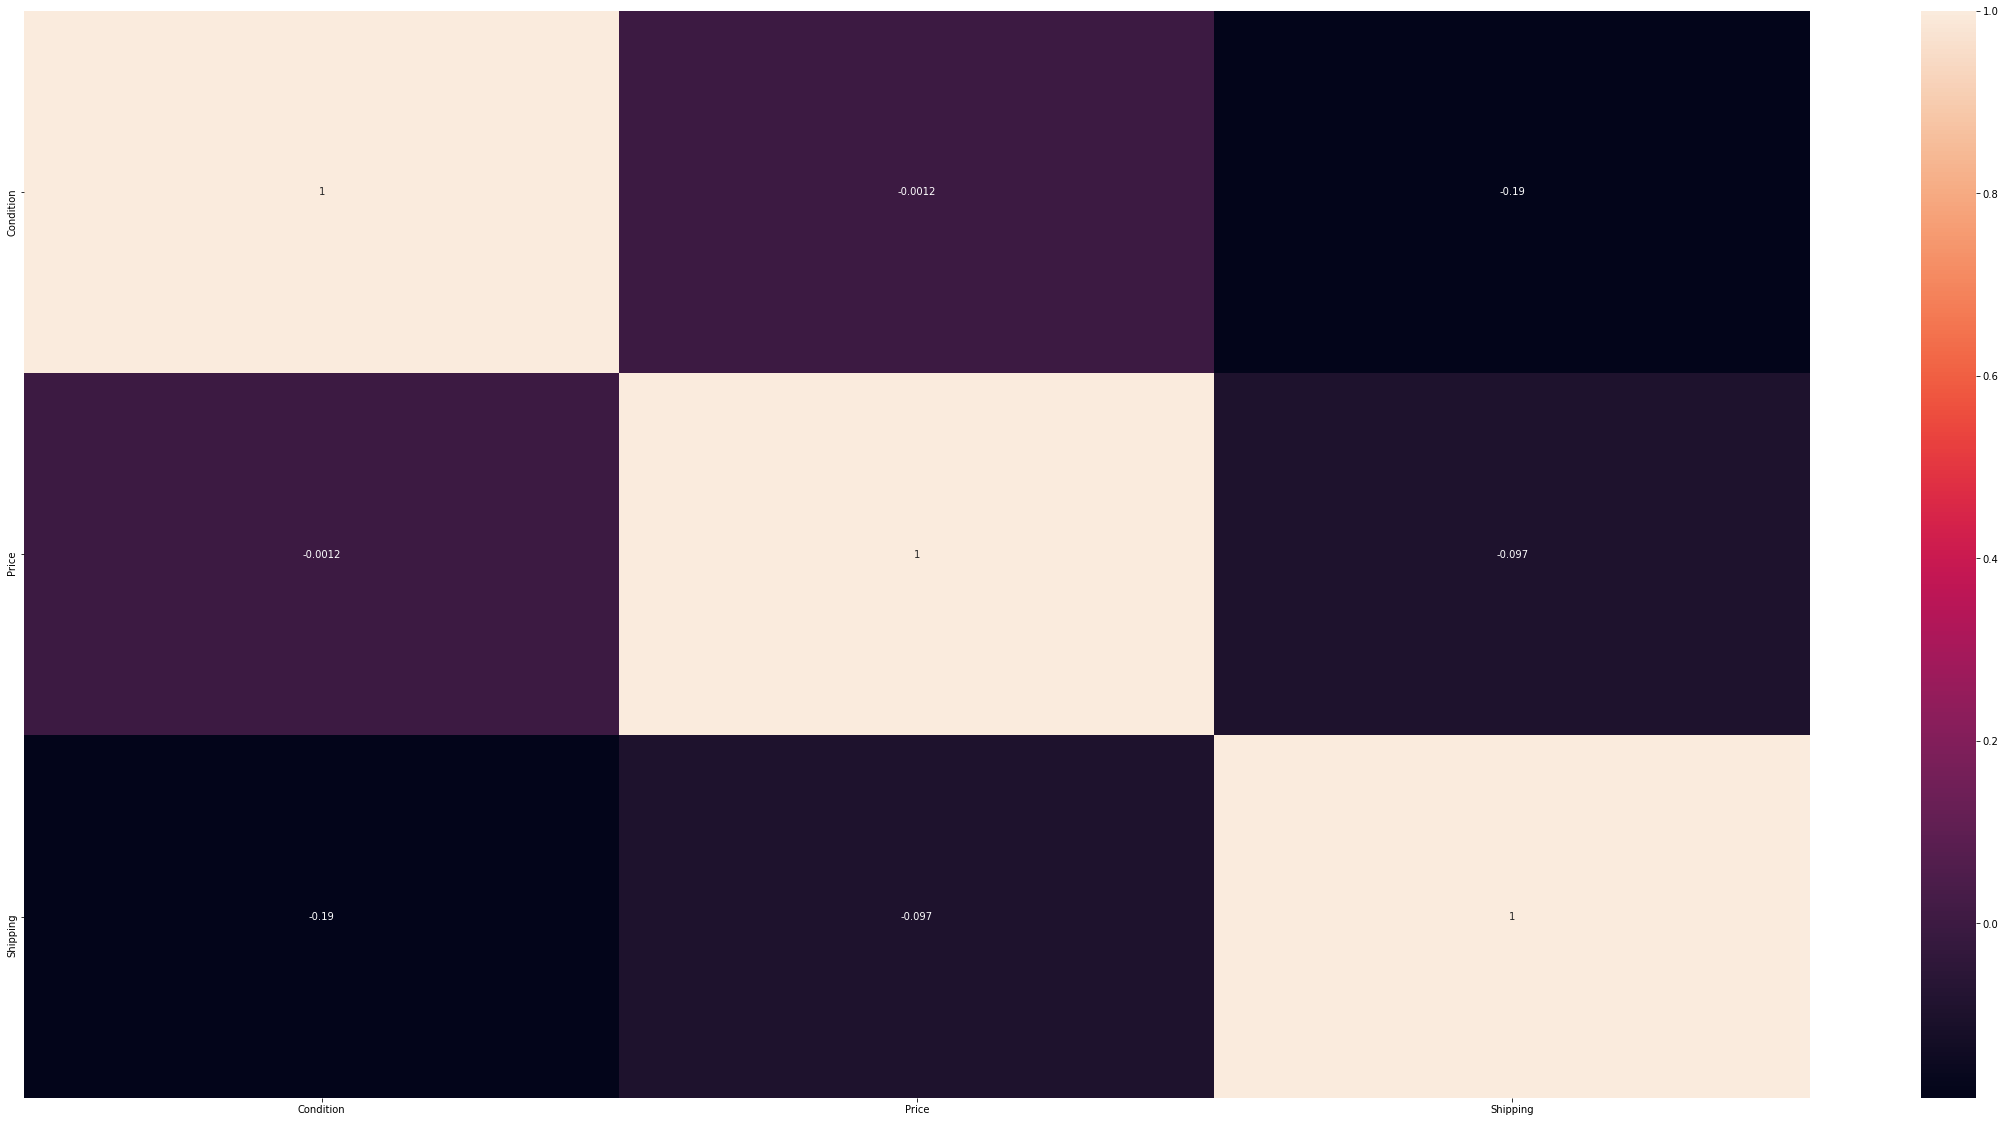

In [11]:
# Lets take a look at a heatmap too while we're at it

plt.figure(figsize=(40, 20))
sns.heatmap(mercari_data.corr(), annot=True)

Judging by the colors of the heatmap, condition and shipping appear to have very little correlation with each other,
while the two potential correlations we discussed earlier may be worth entertaining and investigating further. Lets start with our primary interest, Price vs. Condition

<AxesSubplot:xlabel='Condition', ylabel='Price'>

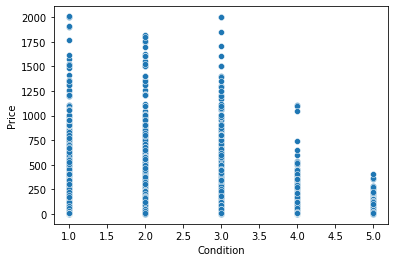

In [23]:
sns.scatterplot(data=mercari_data, x='Condition', y='Price')

<AxesSubplot:xlabel='Condition', ylabel='Price'>

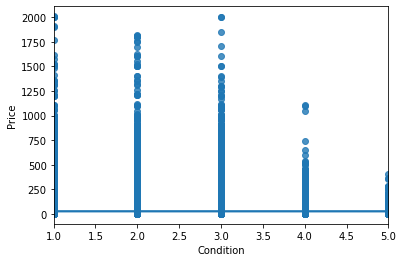

In [64]:
sns.regplot(data=mercari_data, x='Condition', y='Price')

In [65]:
mercari_data.groupby(['Condition'])['Price'].mean()

Condition
1    26.494803
2    27.571188
3    26.520995
4    24.335394
5    31.017523
Name: Price, dtype: float64

It's difficult to visualize the line of best fit because the mean of prices grouped by condition is far smaller 
compared to the range of possible values that Price can have. We will simply obtain the slope of the best fit line
using non-visual methods.

In [67]:
m, b = np.polyfit(mercari_data['Condition'], mercari_data['Price'], 1)
print("Slope: " + str(m))

Slope: -0.04962668308644787


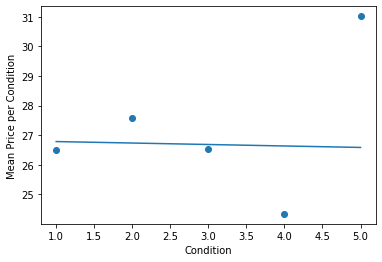

In [73]:
# Graphing Condition vs. Mean of price grouped by Condition, with best fit line included

plt.xlabel("Condition")
plt.ylabel("Mean Price per Condition")
plt.scatter(range(1, 6), mercari_data.groupby(['Condition'])['Price'].mean())
plt.plot(range(1, 6), range(1, 6) * m + b)

This at least confirms our predictions that Price should correlate negatively to the value of Condition. Because
afterall, the better condition an item is in, the more the seller should be able to charge for it. Now lets investigate the effect of Shipping on Price. Just as a reminder, a value of 0 indicates that the seller isn't paying for shipping and needs to come from the buyer. A value of 1 indicates that the shipping will be paid for by the seller.

In [77]:
# First lets see the mean price grouped by Shipping

mercari_data.groupby(['Shipping'])['Price'].mean()

Shipping
0    30.107849
1    22.571784
Name: Price, dtype: float64

Interesting result, as it appears that sellers tend to charge higher prices when they are also not paying for shipping
as well. Lets see the distribution of listings per each shipping status:

In [79]:
mercari_data.groupby(['Shipping']).count()['Price']

Shipping
0    579433
1    469142
Name: Price, dtype: int64

These two groups are roughly equal, so this eliminates the possibility that either group is overrepresented compared
to the other.

<AxesSubplot:xlabel='Shipping', ylabel='Price'>

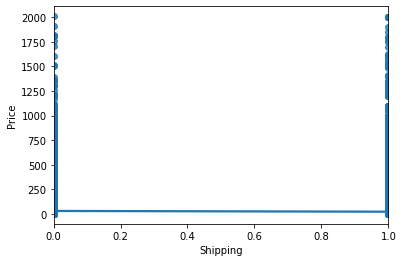

In [74]:
sns.regplot(data=mercari_data, x='Shipping', y='Price')

In [76]:
m, b = np.polyfit(mercari_data['Shipping'], mercari_data['Price'], 1)
print("Slope: " + str(m))

Slope: -7.536064298785073


The slope of the best fit line is also in line with the results thus far. Listings that require the buyer to pay for
shipping also charge higher prices overall. However this is merely correlation. Perhaps pricier listings are higher in
demand, and the seller might be able to push the shipping fees onto the buyer since they would be willing to pay it
anyways.

Let us now take a look at the non-numeric data, starting with Brand.

In [6]:
# Get number of unique values of 'Brand'

mercari_data['Brand'].nunique()

# Lets then identify the Brands that are most present in the data

mercari_data['Brand'].value_counts()

Nike                    38161
PINK                    38123
Victoria's Secret       34159
LuLaRoe                 21900
Apple                   12222
                        ...  
P&N                         1
Oregon Scientific           1
Da-Nang                     1
BebeSounds                  1
Lime Crime Cosmetics        1
Name: Brand, Length: 4383, dtype: int64

In [5]:
# Get number of unique values of 'Category'

mercari_data['Category'].nunique()

1258